In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Preparación de los datos

In [81]:
# Especificar los tipos de datos para las columnas problemáticas
dtype_dict = {
    'gpu_spec': 'string', 
    'qos': 'string',
    'pod_phase': 'string'
}

extracted_data = pd.read_csv('data/concatenated_openb_pod_all.csv', dtype=dtype_dict)

extracted_data.head()

,name,cpu_milli,memory_mib,num_gpu,gpu_milli,gpu_spec,qos,pod_phase,creation_time,deletion_time,scheduled_time,source_file
0,openb-pod-0000,12000,16384,1,1000,<NA>,LS,Running,0.0,12537496.0,0.0,openb_pod_list_cpu0.csv
1,openb-pod-0001,6000,12288,1,460,<NA>,LS,Running,427061.0,12902960.0,427061.0,openb_pod_list_cpu0.csv
2,openb-pod-0002,12000,24576,1,1000,<NA>,LS,Running,1558381.0,12902960.0,1558381.0,openb_pod_list_cpu0.csv
3,openb-pod-0003,6000,12288,1,460,<NA>,LS,Running,2690044.0,12902960.0,2690044.0,openb_pod_list_cpu0.csv
4,openb-pod-0004,12000,16384,1,1000,<NA>,LS,Running,2758084.0,12902960.0,2758084.0,openb_pod_list_cpu0.csv


In [82]:
extracted_data.describe()

,cpu_milli,memory_mib,num_gpu,gpu_milli,creation_time,deletion_time,scheduled_time
count,199197.000000,199197.000000,199197.000000,199197.000000,1.645580e+05,1.645580e+05,1.458250e+05
mean,10717.539280,38222.719032,0.949839,678.128436,1.146626e+07,1.149092e+07,1.144099e+07
std,9898.142775,40961.400145,0.828167,366.365105,9.626859e+05,9.035249e+05,9.682643e+05
min,1000.000000,0.000000,0.000000,0.000000,0.000000e+00,9.538584e+06,0.000000e+00
25%,4000.000000,15258.000000,1.000000,460.000000,1.069520e+07,1.070431e+07,1.066806e+07
50%,11300.000000,33792.000000,1.000000,810.000000,1.147048e+07,1.148005e+07,1.141606e+07
75%,12000.000000,49152.000000,1.000000,1000.000000,1.228024e+07,1.229824e+07,1.225873e+07
max,120200.000000,737280.000000,8.000000,1000.000000,1.290176e+07,1.290296e+07,1.290176e+07


In [83]:
extracted_data.describe(include=['string','object'])

,name,gpu_spec,qos,pod_phase,source_file
count,199197,6692,164558,164558,199197
unique,10094,17,4,4,24
top,openb-pod-7063,T4,LS,Running,openb_pod_list_cpu300.csv
freq,24,3474,88493,103210,10094


In [84]:
extracted_data.isnull().sum()


name                   0
cpu_milli              0
memory_mib             0
num_gpu                0
gpu_milli              0
gpu_spec          192505
qos                34639
pod_phase          34639
creation_time      34639
deletion_time      34639
scheduled_time     53372
source_file            0
dtype: int64

In [85]:
filtered_data = extracted_data[
    (extracted_data['scheduled_time'] > 0) & 
    (extracted_data['pod_phase'] != 'Running')
]
#filtered_data = filtered_data.rename(columns={'num_gpu': 'workers'})

pod_phase_counts = filtered_data['pod_phase'].value_counts()

# Mostrar los resultados
print(pod_phase_counts)

pod_phase
Failed       39209
Succeeded     3406
Name: count, dtype: Int64


In [86]:
# Mantener la primera versión de un registro duplicado en un nuevo dataframe
no_dups_df = filtered_data.drop_duplicates(keep='first', inplace=False)

# Contar duplicados
dups_rows = filtered_data[filtered_data.duplicated(keep='first')]

# Calcular el porcentaje de duplicados
porcentaje_dups = (dups_rows.shape[0] / filtered_data.shape[0]) * 100

# Imprimir resultados:
print(f'Cantidad de Registros Originales: {filtered_data.shape[0]}')
print(f"Cantidad de Registros duplicados: {dups_rows.shape[0]}")
print(f"Porcentaje de duplicados sobre la muestra original: {porcentaje_dups:.2f}%")
print(f"Cantidad de Registros sin dups  : {no_dups_df.shape[0]}")


Cantidad de Registros Originales: 42615
Cantidad de Registros duplicados: 0
Porcentaje de duplicados sobre la muestra original: 0.00%
Cantidad de Registros sin dups  : 42615


In [87]:
data = filtered_data.copy()

# Reemplazar valores <NA> con '0' en columnas de tipo string
for col in data.select_dtypes(include=['string']).columns:
    data[col] = data[col].fillna('0')

# Reemplazar valores <NA> con 0 en columnas numéricas
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    data[col] = data[col].fillna(0)

data.fillna(0, inplace=True)  


In [88]:
# Agregar columnas adicionales para el análisis
data["cpu_cores"] = data["cpu_milli"] / 1000    # Convierte miliCPU a cores
data["gpu_cores"] = data["gpu_milli"] / 1000    # Convierte miliGPU a cores
data['memory_gbs'] = data['memory_mib'] / 1024  # Convertir MiB a GiB
data["total_usage"] = data["cpu_cores"] + data["gpu_cores"] # Calcula el uso total de CPU y GPU en cores
data["cpu_gpu_ratio"] = data["cpu_cores"] / (data["gpu_cores"] + 1e-6) # Calcula la relación entre el uso de CPU y GPU (evitando la división por cero)


- La conversión de miliCPU y miliGPU a cores se realizó para expresar el uso de recursos en una unidad más interpretable.
- La variable total_usage se creó para tener una medida agregada del consumo de recursos, lo que puede ser útil para simplificar el modelado.
- La variable cpu_gpu_ratio se calculó para analizar cómo se balancea el uso de CPU y GPU, lo que puede proporcionar información sobre la eficiencia de las tareas.

In [89]:
data[['cpu_cores', 'memory_gbs','gpu_cores','total_usage', 'cpu_gpu_ratio']].describe()

,cpu_cores,memory_gbs,gpu_cores,total_usage,cpu_gpu_ratio
count,42615.000000,42615.000000,42615.000000,42615.000000,4.261500e+04
mean,6.242175,18.664750,0.848119,7.090294,6.092449e+04
std,11.313165,50.134321,0.154220,11.348185,1.138318e+06
min,3.152000,0.000000,0.000000,3.742000,3.151997e+00
25%,3.152000,5.468750,0.810000,3.962000,3.891353e+00
50%,3.152000,5.468750,0.810000,3.962000,3.891353e+00
75%,4.000000,10.351562,1.000000,4.522000,3.999996e+00
max,120.200000,720.000000,1.000000,121.200000,3.200000e+07


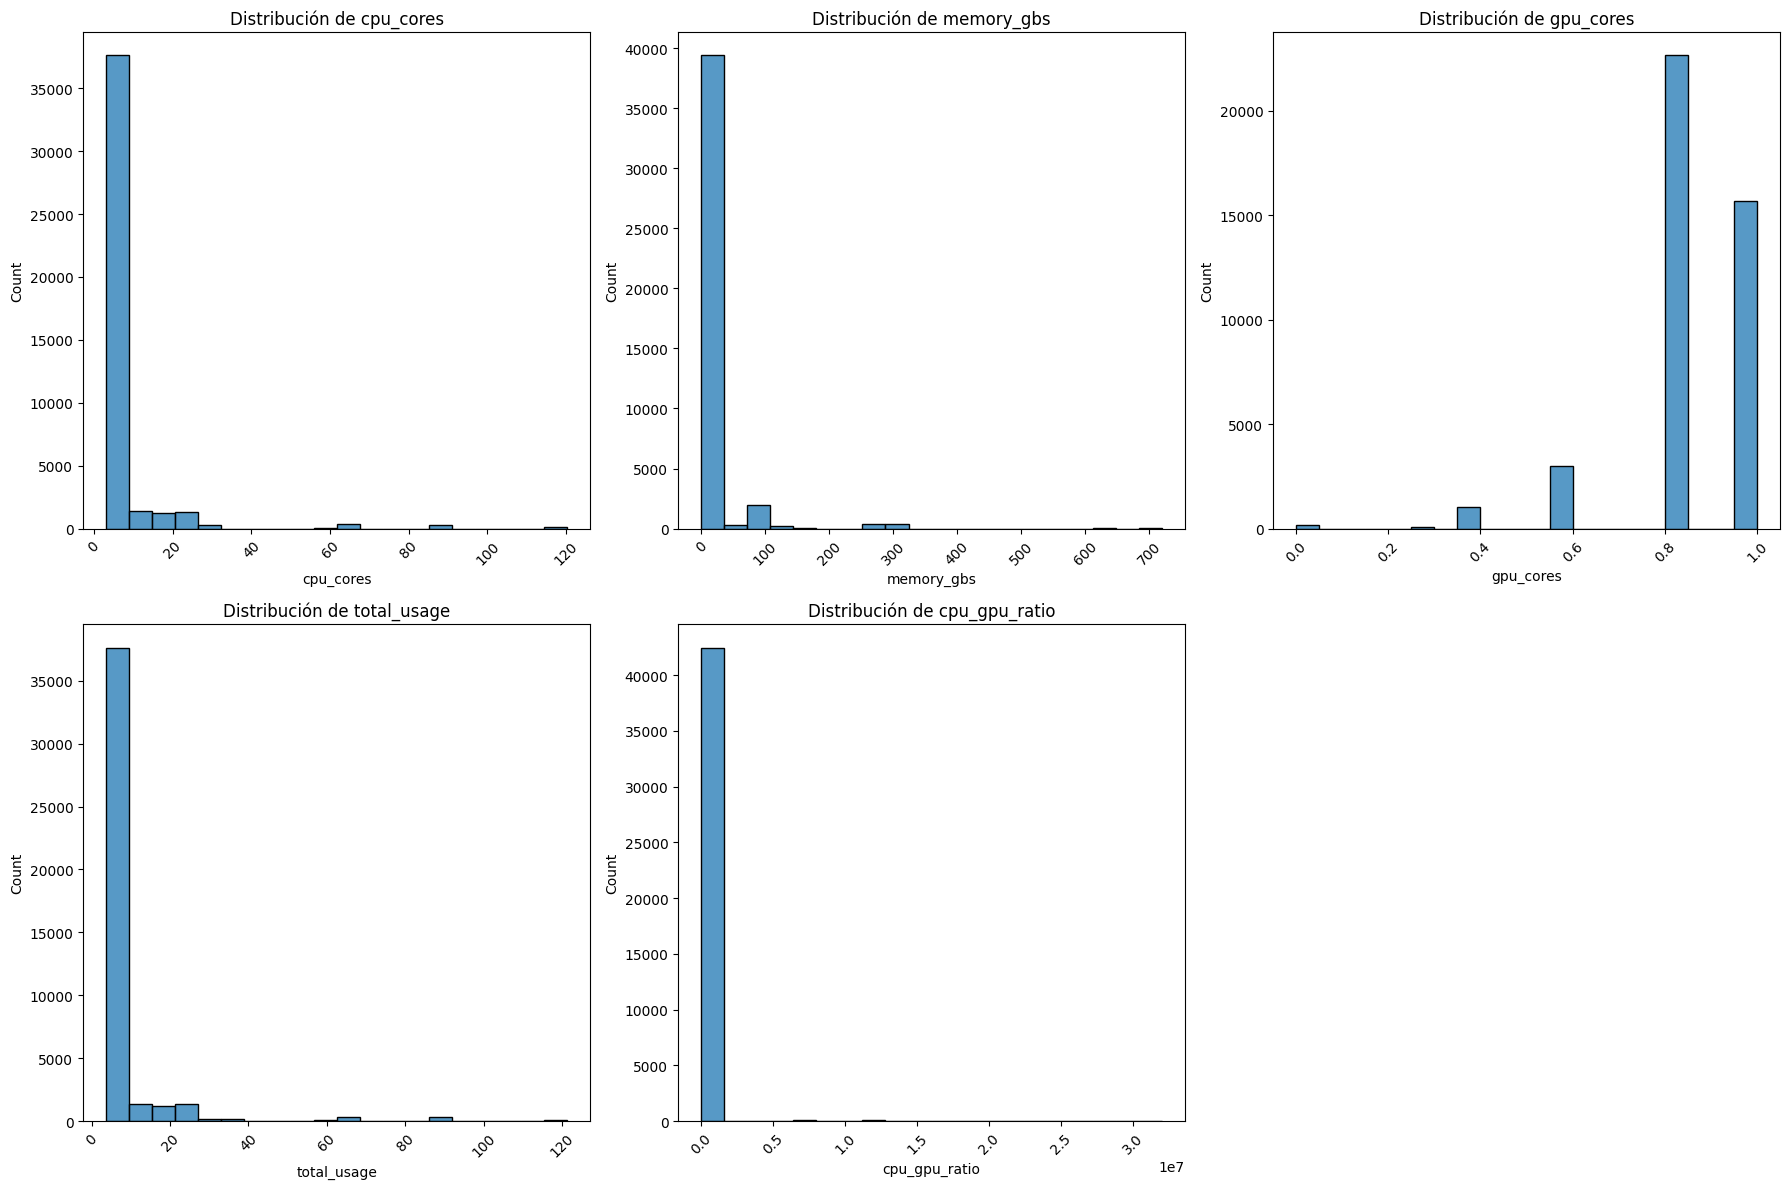

In [90]:
# Seleccionar columnas numéricas
numeric_data = data
numeric_columns = ['cpu_cores', 'memory_gbs','gpu_cores','total_usage', 'cpu_gpu_ratio'] 

subset_df = numeric_data[numeric_columns]

# Configurar subplots para mostrar 3 gráficos por fila
num_cols = 3
num_plots = len(subset_df.columns)
num_rows = (num_plots + num_cols - 1) // num_cols  # Calcular el número de filas necesarias

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))  # Ajustar tamaño
axes = axes.flatten()  # Aplanar los ejes para iterar fácilmente

for i, col in enumerate(subset_df.columns):
    sns.histplot(data=subset_df, x=col, bins=20, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar gráficos vacíos si hay menos de num_rows * num_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

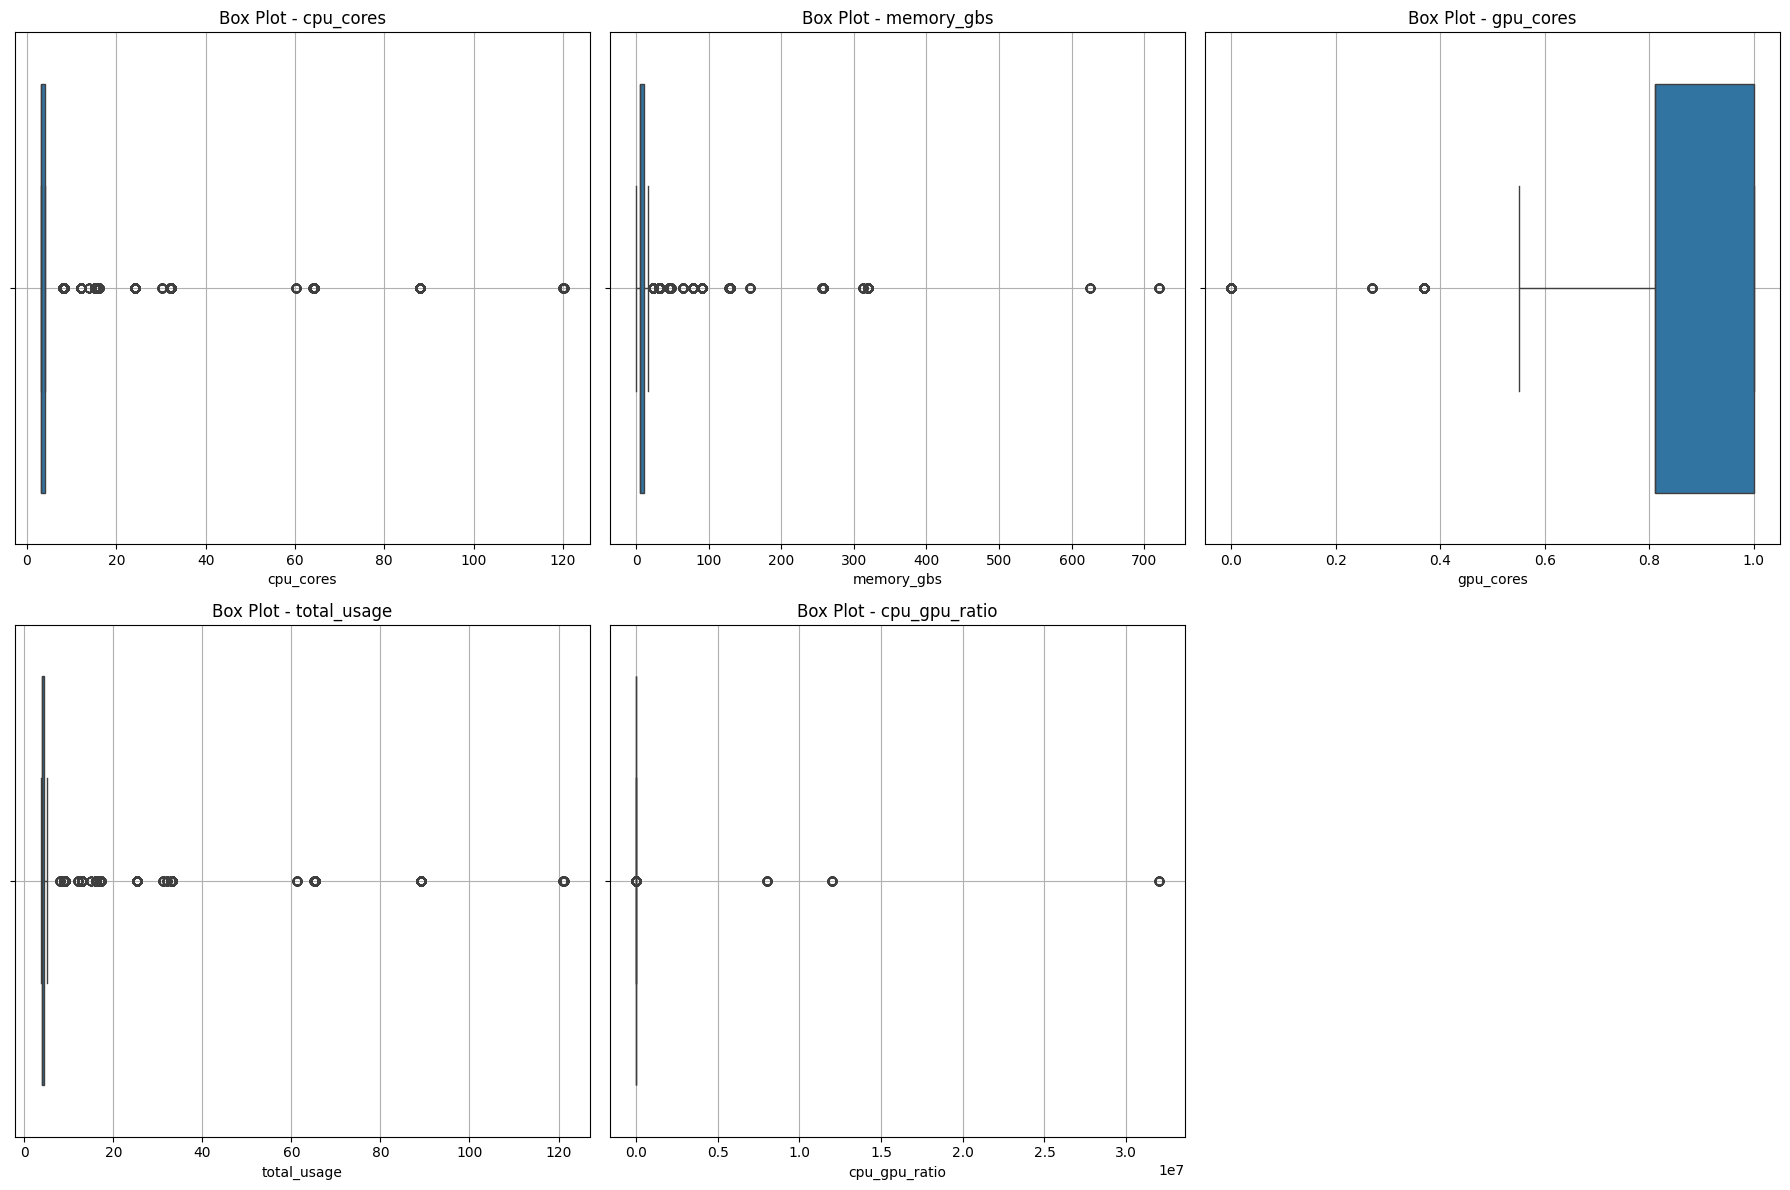

In [91]:

box_plot_df = numeric_data[numeric_columns]
#box_plot_df = box_plot_df[box_plot_df['total_usage'] <= 40]

# Calcular el número de filas necesarias
num_cols = 3
num_plots = len(box_plot_df.columns)
num_rows = (num_plots + num_cols - 1) // num_cols  # Calcular el número de filas necesarias


# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
axes = axes.flatten()  

# Hide unused subplots if any
for ax in axes[num_plots:]:
    ax.axis('off')

# Plot each numeric column as a boxplot
for ax, column in zip(axes, box_plot_df):
    sns.boxplot(data=box_plot_df, x=column, ax=ax)
    ax.set_title(f"Box Plot - {column}")
    ax.set_xlabel(column)
    ax.grid(True)

plt.tight_layout()  # Prevent overlapping
plt.show()

### Exportar resultados limpios para análisis

In [92]:
data.to_csv('data/cleaned_data.csv', index=False)

In [93]:
data.head()

,name,cpu_milli,memory_mib,num_gpu,gpu_milli,gpu_spec,qos,pod_phase,creation_time,deletion_time,scheduled_time,source_file,cpu_cores,gpu_cores,memory_gbs,total_usage,cpu_gpu_ratio
15,openb-pod-0015,88000,327680,8,1000,0,Burstable,Succeeded,9437497.0,10769854.0,9437497.0,openb_pod_list_cpu0.csv,88.000,1.0,320.00000,89.000,87.999912
31,openb-pod-0031,3152,5600,1,1000,0,BE,Failed,9965463.0,9965645.0,9965463.0,openb_pod_list_cpu0.csv,3.152,1.0,5.46875,4.152,3.151997
34,openb-pod-0034,3152,5600,1,1000,0,BE,Failed,9967204.0,9967404.0,9967204.0,openb_pod_list_cpu0.csv,3.152,1.0,5.46875,4.152,3.151997
39,openb-pod-0039,3152,5600,1,1000,0,BE,Failed,9976185.0,9976497.0,9976185.0,openb_pod_list_cpu0.csv,3.152,1.0,5.46875,4.152,3.151997
40,openb-pod-0040,3152,5600,1,1000,0,BE,Failed,9977555.0,9977866.0,9977555.0,openb_pod_list_cpu0.csv,3.152,1.0,5.46875,4.152,3.151997


In [ ]:
import pandas as pd

df = data.copy()

#  Supongamos que el error ocurre en la columna 'mi_columna'

#  1. Imprimir los tipos de datos
print(df.info())

#  2. Encontrar valores no numéricos
non_numeric_values = df[pd.to_numeric(df['mi_columna'], errors='coerce').isna()]
if not non_numeric_values.empty:
    print("La columna 'mi_columna' contiene valores no numéricos:")
    print(non_numeric_values['mi_columna'].head(10))

#  3. Corregir los valores no numéricos (ejemplo: eliminar las filas)
df = df[pd.to_numeric(df['mi_columna'], errors='coerce').notna()]

#  4. Convertir la columna a numérica
df['mi_columna'] = pd.to_numeric(df['mi_columna'])

#  5. Volver a imprimir los tipos de datos para verificar
print(df.info())

#  Ahora puedes continuar con tus operaciones numéricas
#  Por ejemplo:
#  print(df['mi_columna'].mean())

<class 'pandas.core.frame.DataFrame'>
Index: 42615 entries, 15 to 164557
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            42615 non-null  object 
 1   cpu_milli       42615 non-null  int64  
 2   memory_mib      42615 non-null  int64  
 3   num_gpu         42615 non-null  int64  
 4   gpu_milli       42615 non-null  int64  
 5   gpu_spec        42615 non-null  string 
 6   qos             42615 non-null  string 
 7   pod_phase       42615 non-null  string 
 8   creation_time   42615 non-null  float64
 9   deletion_time   42615 non-null  float64
 10  scheduled_time  42615 non-null  float64
 11  source_file     42615 non-null  object 
 12  cpu_cores       42615 non-null  float64
 13  gpu_cores       42615 non-null  float64
 14  memory_gbs      42615 non-null  float64
 15  total_usage     42615 non-null  float64
 16  cpu_gpu_ratio   42615 non-null  float64
dtypes: float64(8), int64(4), object(2)

KeyError: 'mi_columna'